In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report,plot_confusion_matrix
%matplotlib inline
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import vgg16, inception_v3, mobilenet, xception
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import datetime
import json
import requests
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from skimage import io
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from PIL import Image
from sklearn.metrics import f1_score,confusion_matrix,roc_curve,roc_auc_score,precision_score,f1_score,recall_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from keras.models import Model,Input
from keras.layers import Flatten,Input,Dense,Conv2D, MaxPooling2D,Dropout,BatchNormalization,Embedding,LSTM,Activation
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,TensorBoard,ModelCheckpoint
from keras.models import load_model

In [2]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/inception_features.csv')

In [3]:
df = data[data.dank_level==0].sample(n=946,replace=False)
data = data[data['upvote ratio']>0.0016]
data = pd.concat([data,df],ignore_index=True)
data = shuffle(data)
data = data.reset_index(drop=True)

In [4]:
train_x,test_x,train_y,test_y = train_test_split(data['media'],data['dank_level'],stratify=data['dank_level'],test_size=0.25,random_state=42)

## VGG16

In [5]:
#loading vgg16 
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

In [7]:
def image_data(df):
    ls = []
    for url in tqdm(df.values): 
        response = requests.get(url, stream=True)
            #opening t he image
        image= np.array(Image.open(response.raw))
        image= np.resize(image,(224,224,3))
        image = image.astype('float32')
        image /= 255  
        ls.append(image)   
    return ls 

train_image = image_data(train_x)
test_image = image_data(test_x)

100%|██████████| 473/473 [00:45<00:00, 10.43it/s]


In [8]:
input = Input(shape=(224,224,3))
vgg_ = vgg_model(input)
dense1 = Dense(512,activation='relu',kernel_initializer='he_normal',input_dim=(224,224,3))(vgg_)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(512,activation='relu',kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.15)(dense2)
output = Dense(1,activation='sigmoid')(dropout2)
vgg_model = Model(inputs=input,outputs=output)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 25088)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513 

In [17]:
tf.keras.backend.clear_session()
log_dir="/content/"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
vgg_model.compile(optimizer=Adam(learning_rate=0.0006,decay = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
vgg_model.fit(np.array(train_image,np.float32),train_y,validation_split=0.2,epochs=10,batch_size=128,callbacks=[checkpoint,tensorboard_callback],verbose=1)

Epoch 1/10
9/9 [==============================] - 4s 374ms/step - loss: 0.6939 - accuracy: 0.6079 - val_loss: 0.7288 - val_accuracy: 0.4965

Epoch 00001: val_loss improved from inf to 0.72883, saving model to weights.hdf5
Epoch 2/10
9/9 [==============================] - 3s 291ms/step - loss: 0.5977 - accuracy: 0.6678 - val_loss: 0.7567 - val_accuracy: 0.4930

Epoch 00002: val_loss did not improve from 0.72883
Epoch 3/10
9/9 [==============================] - 3s 291ms/step - loss: 0.5554 - accuracy: 0.7022 - val_loss: 0.8071 - val_accuracy: 0.4577

Epoch 00003: val_loss did not improve from 0.72883
Epoch 4/10
9/9 [==============================] - 3s 291ms/step - loss: 0.5282 - accuracy: 0.7048 - val_loss: 0.8155 - val_accuracy: 0.5070

Epoch 00004: val_loss did not improve from 0.72883
Epoch 5/10
9/9 [==============================] - 3s 294ms/step - loss: 0.5066 - accuracy: 0.7427 - val_loss: 0.8077 - val_accuracy: 0.4648

Epoch 00005: val_loss did not improve from 0.72883
Epoch 6/10

In [19]:
predictions = vgg_model.predict(np.array(test_image,np.float32))
y_pred = []
for pred in predictions:
    if pred < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [20]:
print("Accuracy:",accuracy_score(test_y, y_pred))
print("Precision: ",precision_score(test_y,y_pred,average='weighted'))
print("Recall: ",recall_score(test_y, y_pred,average='weighted'))
print("F-1 Score: ",f1_score(test_y, y_pred,average='weighted'))

Accuracy: 0.5052854122621564
Precision:  0.5056490439458483
Recall:  0.5052854122621564
F-1 Score:  0.5014488610656378


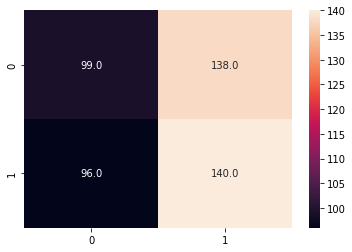

In [21]:
confusionmatrix=confusion_matrix(test_y,y_pred,labels=[0,1])
sns.heatmap(confusionmatrix,annot=True,fmt='.1f')

No handles with labels found to put in legend.


AUC= 0.5066688121290137


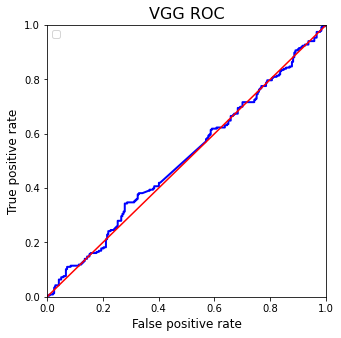

In [22]:
y_pred = vgg_model.predict(np.array(test_image,np.float32))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1, sample_weight=None)
auc = roc_auc_score(test_y, y_pred, sample_weight=None)
print("AUC=", auc)

# plot ROC curves 
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,linewidth=2.0,color='blue')
plt.plot([0,1],[0,1],color='red')
plt.legend() 
plt.xlabel('False positive rate',fontsize=12); plt.ylabel('True positive rate',fontsize=12)
plt.xlim([0,1]); plt.ylim([0,1])
plt.title('VGG ROC', fontsize=16)
plt.show()

# XCEPTION

In [23]:
def image_data(df):
    ls = []
    for url in tqdm(df.values): 
        response = requests.get(url, stream=True)
            #opening t he image
        image= np.array(Image.open(response.raw))
        image= np.resize(image,(299,299,3))
        image = image.astype('float32')
        image /= 255  
        ls.append(image)   
    return ls 

train_image = image_data(train_x)
test_image = image_data(test_x)

100%|██████████| 473/473 [00:46<00:00, 10.24it/s]


In [24]:
xception = xception.Xception(weights='imagenet',include_top=False,input_shape=(299, 299, 3),pooling='avg')
output = xception.layers[-1].output
output = Flatten()(output)
xception_model = Model(xception.input, output)
xception_model.trainable = False

In [25]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [26]:
tf.keras.backend.clear_session()
input = Input(shape=(299,299,3))
xception_ = xception_model(input)
dense1 = Dense(64,activation='relu',kernel_initializer='he_normal',input_dim=(299,299,3))(xception_)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(32,activation='relu',kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.15)(dense2)
output = Dense(1,activation='sigmoid')(dropout2)
xception_model = Model(inputs=input,outputs=output)
xception_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

In [33]:
tf.keras.backend.clear_session()
log_dir="/content/"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
xception_model.compile(optimizer=Adam(learning_rate=0.0006,decay = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
xception_model.fit(np.array(train_image,np.float32),train_y.astype(np.float32),validation_split=0.2,epochs=10,batch_size=64,callbacks=[checkpoint,tensorboard_callback],verbose=1)

Epoch 1/10
18/18 [==============================] - 11s 434ms/step - loss: 0.6054 - accuracy: 0.6714 - val_loss: 0.7212 - val_accuracy: 0.5070

Epoch 00001: val_loss improved from inf to 0.72121, saving model to weights.hdf5
Epoch 2/10
18/18 [==============================] - 6s 325ms/step - loss: 0.5880 - accuracy: 0.6890 - val_loss: 0.7257 - val_accuracy: 0.5106

Epoch 00002: val_loss did not improve from 0.72121
Epoch 3/10
18/18 [==============================] - 6s 326ms/step - loss: 0.5675 - accuracy: 0.7057 - val_loss: 0.7387 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.72121
Epoch 4/10
18/18 [==============================] - 6s 327ms/step - loss: 0.5774 - accuracy: 0.6881 - val_loss: 0.7463 - val_accuracy: 0.5246

Epoch 00004: val_loss did not improve from 0.72121
Epoch 5/10
18/18 [==============================] - 6s 328ms/step - loss: 0.5433 - accuracy: 0.7313 - val_loss: 0.7623 - val_accuracy: 0.5035

Epoch 00005: val_loss did not improve from 0.72121

In [35]:
predictions = xception_model.predict(np.array(test_image,np.float32))
y_pred = []
for pred in predictions:
    if pred < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [36]:
print("Accuracy:",accuracy_score(test_y, y_pred))
print("Precision: ",precision_score(test_y,y_pred,average='weighted'))
print("Recall: ",recall_score(test_y, y_pred,average='weighted'))
print("F-1 Score: ",f1_score(test_y, y_pred,average='weighted'))

Accuracy: 0.5116279069767442
Precision:  0.5120442362609212
Recall:  0.5116279069767442
F-1 Score:  0.5090167960571912


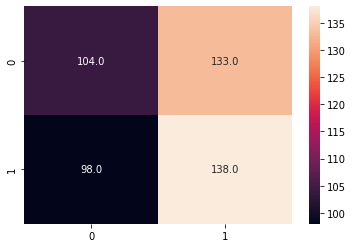

In [37]:
confusionmatrix=confusion_matrix(test_y,y_pred,labels=[0,1])
sns.heatmap(confusionmatrix,annot=True,fmt='.1f')

No handles with labels found to put in legend.


AUC= 0.543329399985697


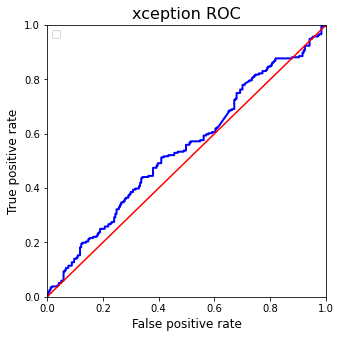

In [38]:
y_pred = xception_model.predict(np.array(test_image,np.float32))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1, sample_weight=None)
auc = roc_auc_score(test_y, y_pred, sample_weight=None)
print("AUC=", auc)

# plot ROC curves 
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,linewidth=2.0,color='blue')
plt.plot([0,1],[0,1],color='red')
plt.legend() 
plt.xlabel('False positive rate',fontsize=12); plt.ylabel('True positive rate',fontsize=12)
plt.xlim([0,1]); plt.ylim([0,1])
plt.title('xception ROC', fontsize=16)
plt.show()

### Inception_V3

In [39]:
inception = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299,3))

In [40]:
output = inception.layers[-1].output
output = Flatten()(output)
inception_model = Model(inception.input, output)
inception_model.trainable = False

In [41]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [69]:
tf.keras.backend.clear_session()
input = Input(shape=(299,299,3))
inception_ = inception_model(input)
dense1 = Dense(64,activation='relu',kernel_initializer='he_normal',input_dim=(299,299,3))(inception_)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(32,activation='relu',kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.15)(dense2)
output = Dense(1,activation='sigmoid')(dropout2)
inception_model = Model(inputs=input,outputs=output)
inception_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 1)                 30202533  
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

In [70]:
inception_model.compile(optimizer=Adam(learning_rate=0.0006,decay = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
inception_model.fit(np.array(train_image,np.float32),train_y.astype(np.float32),validation_split=0.2,epochs=10,batch_size=64,verbose=1)

Epoch 1/10
18/18 [==============================] - 12s 286ms/step - loss: 0.7463 - accuracy: 0.5031 - val_loss: 0.6901 - val_accuracy: 0.5423
Epoch 2/10
18/18 [==============================] - 3s 175ms/step - loss: 0.7100 - accuracy: 0.5366 - val_loss: 0.6896 - val_accuracy: 0.5423
Epoch 3/10
18/18 [==============================] - 3s 174ms/step - loss: 0.7057 - accuracy: 0.5013 - val_loss: 0.6914 - val_accuracy: 0.5423
Epoch 4/10
18/18 [==============================] - 3s 176ms/step - loss: 0.6983 - accuracy: 0.4863 - val_loss: 0.6926 - val_accuracy: 0.5423
Epoch 5/10
18/18 [==============================] - 3s 176ms/step - loss: 0.6939 - accuracy: 0.5093 - val_loss: 0.6930 - val_accuracy: 0.5423
Epoch 6/10
18/18 [==============================] - 3s 174ms/step - loss: 0.6935 - accuracy: 0.4960 - val_loss: 0.6937 - val_accuracy: 0.4577
Epoch 7/10
18/18 [==============================] - 3s 175ms/step - loss: 0.6937 - accuracy: 0.4978 - val_loss: 0.6937 - val_accuracy: 0.4577
Epoch

In [72]:
predictions = inception_model.predict(np.array(test_image,np.float32))
y_pred = []
for pred in predictions:
    if pred < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [73]:
print("Accuracy:",accuracy_score(test_y, y_pred))
print("Precision: ",precision_score(test_y,y_pred,average='weighted'))
print("Recall: ",recall_score(test_y, y_pred,average='weighted'))
print("F-1 Score: ",f1_score(test_y, y_pred,average='weighted'))

Accuracy: 0.5010570824524313
Precision:  0.2510581998757425
Recall:  0.5010570824524313
F-1 Score:  0.33450853110204565


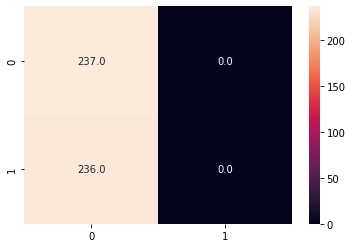

In [75]:
confusionmatrix=confusion_matrix(test_y,y_pred,labels=[0,1])
sns.heatmap(confusionmatrix,annot=True,fmt='.1f')

No handles with labels found to put in legend.


AUC= 0.5580258170635772


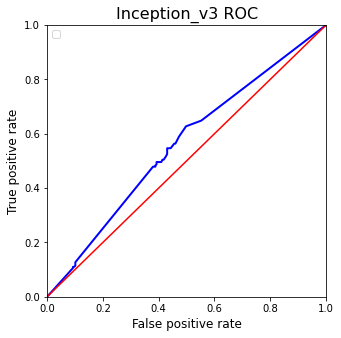

In [76]:
y_pred = inception_model.predict(np.array(test_image,np.float32))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1, sample_weight=None)
auc = roc_auc_score(test_y, y_pred, sample_weight=None)
print("AUC=", auc)

# plot ROC curves 
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,linewidth=2.0,color='blue')
plt.plot([0,1],[0,1],color='red')
plt.legend() 
plt.xlabel('False positive rate',fontsize=12); plt.ylabel('True positive rate',fontsize=12)
plt.xlim([0,1]); plt.ylim([0,1])
plt.title('Inception_v3 ROC', fontsize=16)
plt.show()

In [77]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model", "Pretrained Model","Accuracy", "Precision", "Recall","F1-Score","AUC"])
  
# Add rows
myTable.add_row(["NeuralNetwork", "VGG16", "50.52 %","50.56 %","50.56 %","50.14 %","50.66 %"])
myTable.add_row(["NeuralNetwork", "Xception", "51.16 %","51.20 %","51.16 %","50.90 %","54.33 %"])
myTable.add_row(["NeuralNetwork", "InceptionV3", "50.10 %","25.10 %","50.10 %","33.45 %","55.80 %"])

print(myTable)

+---------------+------------------+----------+-----------+---------+----------+---------+
|     Model     | Pretrained Model | Accuracy | Precision |  Recall | F1-Score |   AUC   |
+---------------+------------------+----------+-----------+---------+----------+---------+
| NeuralNetwork |      VGG16       | 50.52 %  |  50.56 %  | 50.56 % | 50.14 %  | 50.66 % |
| NeuralNetwork |     Xception     | 51.16 %  |  51.20 %  | 51.16 % | 50.90 %  | 54.33 % |
| NeuralNetwork |   InceptionV3    | 50.10 %  |  25.10 %  | 50.10 % | 33.45 %  | 55.80 % |
+---------------+------------------+----------+-----------+---------+----------+---------+


* InceptionV3 is giving good AUC but it only detects not dank points. So we take best pretrained as Xception because it will classify both dank and not dank.

References : 
https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6